# Authors:

Daniel Vila de la Cruz

Sara Gómez Feás

In [3]:
PATH_ZIP='/content/drive/MyDrive/datasets.zip'
!unzip {PATH_ZIP} -d ./

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: ./datasets/faces/faces_dataset_train/w74/45494774_1965-09-14_2014.jpg  
  inflating: ./datasets/faces/faces_dataset_train/w74/46469974_1991-09-10_2014.jpg  
  inflating: ./datasets/faces/faces_dataset_train/w74/46515674_1934-05-27_2010.jpg  
  inflating: ./datasets/faces/faces_dataset_train/w74/46878774_1960-11-01_2009.jpg  
  inflating: ./datasets/faces/faces_dataset_train/w74/4709574_1978-06-10_2011.jpg  
  inflating: ./datasets/faces/faces_dataset_train/w74/4745474_1954-01-04_2012.jpg  
  inflating: ./datasets/faces/faces_dataset_train/w74/4814874_1972-03-31_2010.jpg  
  inflating: ./datasets/faces/faces_dataset_train/w74/4907674_1960-11-22_2003.jpg  
  inflating: ./datasets/faces/faces_dataset_train/w74/5092174_1988-07-13_2012.jpg  
  inflating: ./datasets/faces/faces_dataset_train/w74/5127074_1965-06-20_2012.jpg  
  inflating: ./datasets/faces/faces_dataset_train/w74/5144574_1986-11-07_2009.jpg  
  inflating

In [1]:
# Dataset path
from os import listdir
import os.path

PATH = './datasets/faces_dataset_train/faces_dataset_train/'
PATH_TEST = './datasets/faces_dataset_test/faces_dataset_test/'

assert os.path.exists(PATH), 'Verify the above commands'
assert os.path.exists(PATH_TEST), 'Verify the above commands'

In [2]:
import json

with open(PATH + 'metadata.json') as fIn:
    metadata = json.loads(fIn.read())
with open(PATH_TEST + 'metadata.json') as fIn:
    metadata_test = json.loads(fIn.read())

metadata_example_key = next(iter(metadata.keys()))
metadata_example_value = metadata[metadata_example_key]

print(metadata_example_key, end=' ----> ')
print(metadata_example_value)

i07/nm0322407_rm852269056_1955-3-29_2005.jpg ----> {'age': 50, 'gender': 'M'}


In [3]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Preprocessing data

<TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
Image shape:  (32, 32, 3)
Label:  35


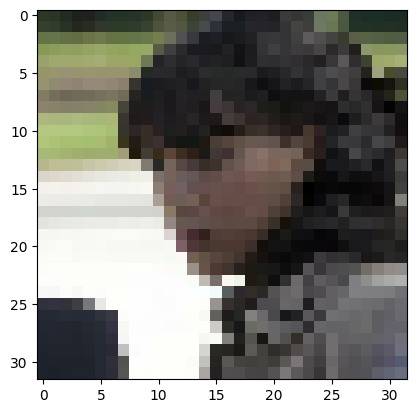

Image shape:  (32, 32, 3)
Label:  34


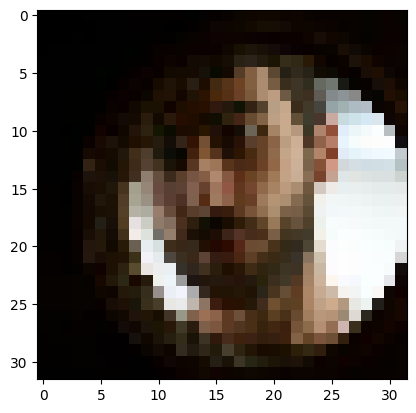

Image shape:  (32, 32, 3)
Label:  37


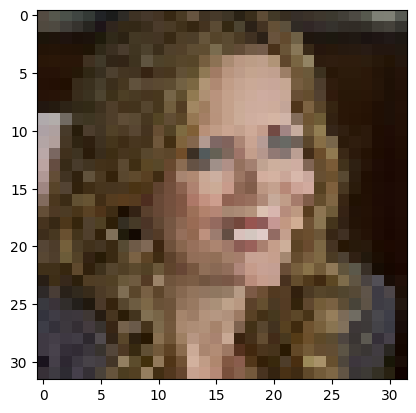

Image shape:  (32, 32, 3)
Label:  14


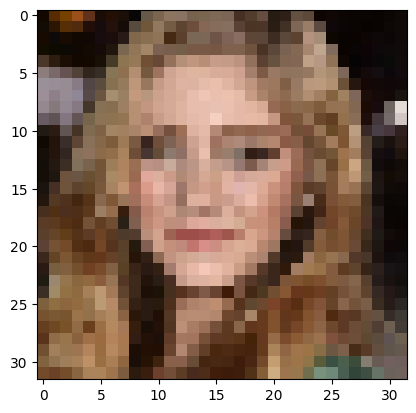

Image shape:  (32, 32, 3)
Label:  71


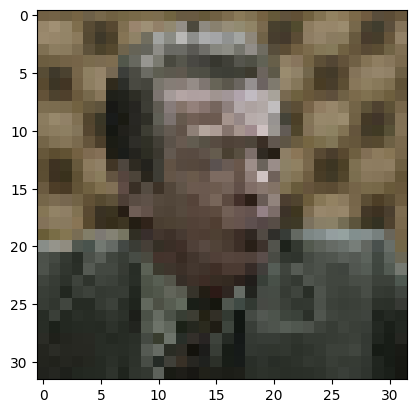

In [4]:
import tensorflow as tf
from matplotlib import pyplot

# Size at which images will be processed
img_height = 32
img_width = 32

def decode_img(img):
    '''Transforms a string that represents the path of an image into a matrix
    (img_height, img_width, 3) of uint8 representing the pixel values
    '''
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size.
    return tf.cast(tf.image.resize(img, [img_height, img_width]),tf.uint8)

def process_path(file_path):
    '''Transforms strings of the form 'path|age|gender' to tuples (image, label)
    '''
    parts = tf.strings.split(file_path, '|')
    age = parts[1]
    age = tf.strings.to_number(age, out_type=tf.dtypes.int32)
    gender = parts[2]
    # Load the raw data from the file as a string
    img = tf.io.read_file(parts[0])
    img = decode_img(img)
    return img, age


def format_metadata(m, path):
    '''Transforms the metadata dictionary m into a list of strings of the form 'path to the image|age|gender'.
    '''
    return list(map(lambda x: '{0}{1}|{2}|{3}'.format(path,x,m[x]['age'],m[x]['gender']),m.keys()))

# We build a dataset of text strings from the metadata
train_metadata = format_metadata(metadata, PATH)
train_ds = tf.data.Dataset.from_tensor_slices(train_metadata)
print(train_ds.take(1))

# Mapping to an image dataset with tags
train_ds = train_ds.shuffle(len(train_ds)).map(process_path)

# Same process for test
test_ds = tf.data.Dataset.from_tensor_slices(format_metadata(metadata_test, PATH_TEST))
test_ds = test_ds.map(process_path)

# Checking
for image, label in train_ds.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    pyplot.imshow(image.numpy())
    pyplot.show()

In [5]:
ds_train_transform = train_ds
ds_test_transform = test_ds
print(train_metadata[0])

./datasets/faces_dataset_train/faces_dataset_train/i07/nm0322407_rm852269056_1955-3-29_2005.jpg|50|M


In [6]:
# OPTIONAL: rescaling input to [-1, 1]
ds_train_transform = ds_train_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))
ds_test_transform = ds_test_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))

# OPTIONAL: rescaled output to [0, 1]
import numpy as np
labels = [int(x.split('|')[1]) for x in train_metadata]
max_age = tf.convert_to_tensor(np.max(labels), tf.float32)
ds_train_transform = ds_train_transform.map(lambda image, label: (image, tf.cast(label, tf.float32)/max_age))
ds_test_transform = ds_test_transform.map(lambda image, label: (image, tf.cast(label, tf.float32)/max_age))

# OPTIONAL: sample age weights
import numpy as np
step = 10
labels = [int(x.split('|')[1]) for x in train_metadata]
freqs, bins = np.histogram(labels, bins=list(range(0,100,step)) + [200])
i_freqs = 1. / freqs
sample_weights = tf.convert_to_tensor(len(i_freqs) * i_freqs / i_freqs.sum())
print(sample_weights)
ds_train_transform = ds_train_transform.map(lambda image, label: (image, label, sample_weights[tf.minimum(tf.cast(label, tf.int32) // step, len(i_freqs) - 1)]))
ds_test_transform = ds_test_transform.map(lambda image, label: (image, label, sample_weights[tf.minimum(tf.cast(label, tf.int32) // step, len(i_freqs) - 1)]))

batch_size = 128
ds_train_batch = ds_train_transform.batch(batch_size)
ds_test_batch = ds_test_transform.batch(batch_size)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
tf.Tensor(
[1.76150383 0.08628557 0.01546083 0.01225852 0.01755069 0.03502511
 0.06879879 0.16056922 0.52553153 7.31701591], shape=(10,), dtype=float64)


# CNN to predict age 

In the previous notebook, we experimented with different approaches for predicting the gender of individuals in images, and the first one of the new approaches turned out to be the most successful. It achieved the highest accuracy on both the training and validation sets.

In this notebook, we will be taking the pre-trained model from this approach and exploring its performance on a regression task: predicting the age of individuals in images. Unlike classification problems, which involve predicting a discrete value, regression problems require predicting a continuous value. This calls for a different type of loss function, such as mean squared error (MSE), and a different output activation function, such as linear.

By using a pre-trained model for gender classification, we can take advantage of the learned features. However, it remains to be seen whether the pre-trained model will be effective in this new context.

## Feature extraction

In this first case, we use a feature extraction approach.

Our model first uses the pre-trained gender classification model to extract features from the input images. These features are then passed through a series of fully connected layers to predict the age of the individual in the image. 

In [7]:
from keras.models import load_model

# load the model trained to predict the gender
base_model = load_model("model_dropout4.h5")

base_model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 32, 32, 3)]       0         
                                                                 
 Conv1 (Conv2D)              (None, 30, 30, 32)        896       
                                                                 
 Conv2 (Conv2D)              (None, 28, 28, 32)        9248      
                                                                 
 Conv3 (Conv2D)              (None, 26, 26, 32)        9248      
                                                                 
 Pool1 (MaxPooling2D)        (None, 13, 13, 32)        0         
                                                                 
 dropout_3 (Dropout)         (None, 13, 13, 32)        0         
                                                                 
 Conv4 (Conv2D)              (None, 11, 11, 64)        18496   

First, we freeze the base model to avoid re-training it.

In [8]:
for layer in base_model.layers:
    layer.trainable = False

Then we create the new model. This new model consists on the convolutional layers of the base model with two more layers on top: a fully connected layer with 128 neurons with a ReLU activation function and an output layer with a single neuron and a linear activation function. We also added a dropout layer with a rate of 0.3 between the dense layers to prevent overfitting, as well as using the early stopping parametter and a learning rate of 0.0005 with ADAM optimizer.

In [9]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

new_model = Sequential()

for layer in base_model.layers[:-4]:
   new_model.add(layer)

new_model.add(Dense(128, activation="relu", name="DenseNew"))
new_model.add(tf.keras.layers.Dropout(0.3))
new_model.add(Dense(1, activation='linear', name="Output_layer"))

new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 30, 30, 32)        896       
                                                                 
 Conv2 (Conv2D)              (None, 28, 28, 32)        9248      
                                                                 
 Conv3 (Conv2D)              (None, 26, 26, 32)        9248      
                                                                 
 Pool1 (MaxPooling2D)        (None, 13, 13, 32)        0         
                                                                 
 dropout_3 (Dropout)         (None, 13, 13, 32)        0         
                                                                 
 Conv4 (Conv2D)              (None, 11, 11, 64)        18496     
                                                                 
 Conv5 (Conv2D)              (None, 9, 9, 64)          3

We add early stopping to monitor the performance of the model on a validation set during training, and stop the training process when the performance on the validation set stops improving.

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

# define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, mode='min')

new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss="mean_squared_error", metrics=["mean_absolute_error"], weighted_metrics=[])
history = new_model.fit(ds_train_batch, epochs=10, validation_data=(ds_test_batch), callbacks=[early_stop])

Epoch 1/10
992/992 [==============================] - 409s 400ms/step - loss: 0.0449 - mean_absolute_error: 0.1240 - val_loss: 0.1742 - val_mean_absolute_error: 0.2627
Epoch 2/10
992/992 [==============================] - 302s 303ms/step - loss: 0.0366 - mean_absolute_error: 0.1133 - val_loss: 0.1650 - val_mean_absolute_error: 0.2576
Epoch 3/10
992/992 [==============================] - 302s 304ms/step - loss: 0.0354 - mean_absolute_error: 0.1116 - val_loss: 0.1636 - val_mean_absolute_error: 0.2568
Epoch 4/10
992/992 [==============================] - 326s 328ms/step - loss: 0.0349 - mean_absolute_error: 0.1109 - val_loss: 0.1590 - val_mean_absolute_error: 0.2543
Epoch 5/10
992/992 [==============================] - 316s 317ms/step - loss: 0.0347 - mean_absolute_error: 0.1107 - val_loss: 0.1606 - val_mean_absolute_error: 0.2551
Epoch 6/10
992/992 [==============================] - 270s 271ms/step - loss: 0.0346 - mean_absolute_error: 0.1105 - val_loss: 0.1585 - val_mean_absolute_error:

In [12]:
new_model.save("model_age_featureExtract.h5")

Since a test set is not available, we will evaluate our model on the validation set and calculate the mean absolute error. Using the maximum age in our dataset, we can determine the average deviation in years of our predictions.

In [13]:
loss,mae=new_model.evaluate(ds_test_batch)

8/8 [==============================] - 5s 173ms/step - loss: 0.1459 - mean_absolute_error: 0.2406


In [14]:
# Check how many years does the error account for
max_age=99
print("Predictions are off by an average of", mae*max_age, "years") 

Predictions are off by an average of 23.816818848252296 years


<Figure size 640x480 with 0 Axes>

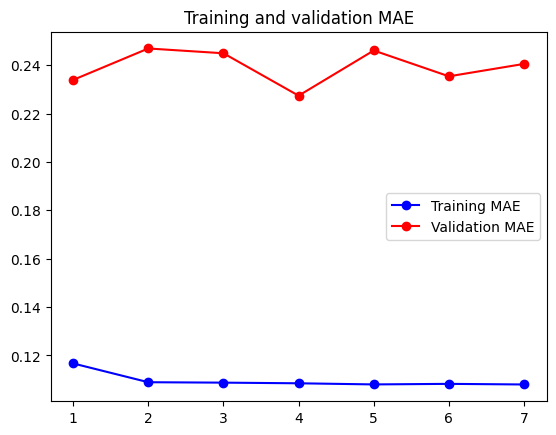

<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
train_mae = history.history["mean_absolute_error"]
val_mae = history.history["val_mean_absolute_error"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(train_mae) + 1)

plt.plot(epochs, train_mae, "b-o", label="Training MAE")
plt.plot(epochs, val_mae, "r-o", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.figure()

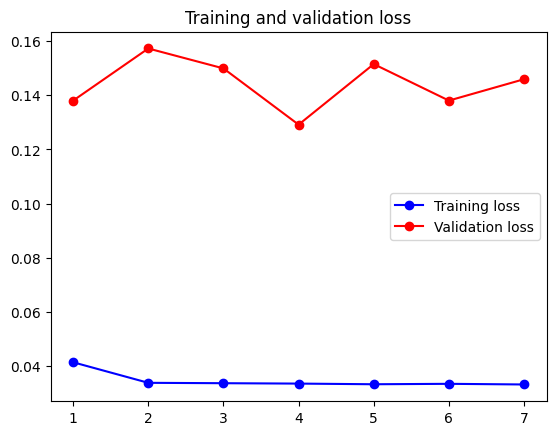

In [16]:
plt.plot(epochs, loss, "b-o", label="Training loss")
plt.plot(epochs, val_loss, "r-o", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# Conclusions

We achieved a MAE of 0.2406 and a loss of 0.1459. Looking at the graphs we can see that there is a bit of overfit, since the validation loss doesn't decrease throught time, and the validation MAE remains considerably higher than the training one.

In order to improve the results, a fine-tunning approach has been developed (see notebook "DL (CNN) Age prediction (Fine-Tunning)").